In [1]:
import torch
import torch.nn.functional as F
import nibabel as nib
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\ShantiChandra\anaconda3\envs\shantichandra_3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ShantiChandra\anaconda3\envs\shantichandra_3.11\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import nibabel as nib

class CAMUSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # 1) find all image files ending in .nii.gz
        image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii.gz')])

        # 2) build a list of (img_file, mask_file) pairs
        self.samples = []
        for img_file in image_files:
            # strip off '.nii.gz' and append '_gt.nii.gz' for the mask
            base = img_file[:-7]
            mask_file = base + '_gt.nii.gz'
            mask_path = os.path.join(mask_dir, mask_file)
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask not found for image {img_file}: expected {mask_file}")
            self.samples.append((img_file, mask_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_file, mask_file = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        # load
        image = nib.load(img_path).get_fdata()
        mask  = nib.load(mask_path).get_fdata()

        # ensure channel dims
        image = np.expand_dims(image, axis=-1)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)
        mask = mask.astype(np.int64)

        # spatial check
        if image.shape[:2] != mask.shape[:2]:
            raise ValueError(f"Spatial mismatch: {img_file} {image.shape[:2]} vs {mask_file} {mask.shape[:2]}")

        # apply transforms
        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug["image"], aug["mask"]
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        # bring mask back to numpy for one‑hot
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        if mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask.squeeze(-1)

        # one‑hot encode into 4 channels (background + 3 classes)
        H, W = mask.shape
        one_hot = np.zeros((4, H, W), dtype=np.float32)
        for c in range(4):
            one_hot[c] = (mask == c).astype(np.float32)

        mask = torch.tensor(one_hot, dtype=torch.float32)
        return image, mask


In [5]:
# -------------------------------------------
# Define Transformations with Data Augmentation
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
]
)

In [17]:

# -------------------------------------------
# Load Dataset and split into Train and Validation sets
img_dir = r"F:\Preprocessed data\CAMUS_IMG_GT\nii_img"
mask_dir = r"F:\Preprocessed data\CAMUS_IMG_GT\nii_gt"
full_dataset = CAMUSDataset(img_dir=img_dir, mask_dir=mask_dir, transform=transform)
dataset_size = len(full_dataset)
print(dataset_size)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


2000


In [ ]:

# ------------------------------------------
model = smp.Unet(
    encoder_name="densenet121",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4, 
    activation=None
)
model = model.to(device)

In [19]:
model

Unet(
  (encoder): DenseNetEncoder(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum

In [20]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

#[batch_size, 1, height, width]
summary(model, input_size=[4, 1, 256 , 256])

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [4, 4, 256, 256]          --
├─DenseNetEncoder: 1-1                        [4, 1, 256, 256]          --
│    └─Sequential: 2-1                        --                        --
│    │    └─Conv2d: 3-1                       [4, 64, 128, 128]         3,136
│    │    └─BatchNorm2d: 3-2                  [4, 64, 128, 128]         128
│    │    └─ReLU: 3-3                         [4, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                    [4, 64, 64, 64]           --
│    │    └─_DenseBlock: 3-5                  [4, 256, 64, 64]          335,040
│    │    └─_Transition: 3-6                  --                        33,280
│    │    └─_DenseBlock: 3-7                  [4, 512, 32, 32]          919,680
│    │    └─_Transition: 3-8                  --                        132,096
│    │    └─_DenseBlock: 3-9                  [4, 1024, 16, 16]         

In [21]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp

# -------------------------------------------
# Combined Dice + Cross‐Entropy Loss for multi‐class segmentation
class DiceCELoss(nn.Module):
    def __init__(
        self,
        dice_weight: float = 1.0,
        ce_weight: float = 1.0,
        smooth: float = 1e-6,
        ce_kwargs: dict = None
    ):
        super().__init__()
        self.dice_weight = dice_weight
        self.ce_weight   = ce_weight
        self.smooth      = smooth
        # you can pass weight, ignore_index, etc. to CE via ce_kwargs
        self.ce_loss = nn.CrossEntropyLoss(**(ce_kwargs or {}))

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # --- Dice part ---
        probs = torch.softmax(logits, dim=1)             # (N, C, H, W)
        N, C, H, W = probs.shape
        probs_flat   = probs.view(N, C, -1)
        targets_flat = targets.view(N, C, -1)

        intersection = (probs_flat * targets_flat).sum(-1)       # (N, C)
        union        = probs_flat.sum(-1) + targets_flat.sum(-1) # (N, C)
        dice_score   = (2 * intersection + self.smooth) / (union + self.smooth)
        dice_loss    = 1.0 - dice_score.mean()

        # --- Cross‐Entropy part ---
        # CE expects class‐indices of shape (N, H, W)
        target_indices = torch.argmax(targets, dim=1).long()
        ce_loss = self.ce_loss(logits, target_indices)

        # --- Combine ---
        return self.dice_weight * dice_loss + self.ce_weight * ce_loss

# -------------------------------------------
# Dice coefficient for logging
def dice_coefficient(outputs: torch.Tensor, targets: torch.Tensor, smooth: float = 1e-8) -> torch.Tensor:
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)
    true  = torch.argmax(targets, dim=1)

    preds_one_hot = nn.functional.one_hot(preds, num_classes=outputs.shape[1])
    true_one_hot  = nn.functional.one_hot(true,  num_classes=outputs.shape[1])

    preds_flat = preds_one_hot.permute(0,3,1,2).view(preds_one_hot.size(0), preds_one_hot.size(3), -1)
    true_flat  = true_one_hot .permute(0,3,1,2).view(true_one_hot.size(0),  true_one_hot.size(3),  -1)

    intersection = (preds_flat * true_flat).sum(-1)
    union        = preds_flat.sum(-1) + true_flat.sum(-1)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.mean()

# -------------------------------------------
# Pixel accuracy for logging
def pixel_accuracy(outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(outputs, dim=1)
    true  = torch.argmax(targets, dim=1)
    return (preds == true).float().mean()

# -------------------------------------------
# Define UNet model
model = smp.Unet(
    encoder_name="densenet121",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,           # number of segmentation classes
    activation=None      # keep None for raw logits (DiceCELoss applies softmax & CE uses logits)
)
model = model.to(device)

# -------------------------------------------
# Instantiate combined loss and optimizer
criterion = DiceCELoss(dice_weight=1.0, ce_weight=1.0, smooth=1e-6)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# -------------------------------------------
# Training Loop
num_epochs = 50

train_loss_list, val_loss_list = [], []
train_dice_list, val_dice_list = [], []
train_acc_list,  val_acc_list  = [], []

for epoch in range(num_epochs):
    # ------ Training ------
    model.train()
    running_loss = 0.0
    dice_epoch, acc_epoch = [], []

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train", leave=False):
        images = images.to(device)
        masks  = masks.to(device).float()  # one-hot encoded masks

        optimizer.zero_grad()
        outputs = model(images)                # raw logits
        loss    = criterion(outputs, masks)    # combined Dice + CE
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        with torch.no_grad():
            dice_epoch.append(dice_coefficient(outputs, masks).item())
            acc_epoch.append(pixel_accuracy(outputs, masks).item())

    train_loss_list.append(running_loss / len(train_loader))
    train_dice_list.append(np.mean(dice_epoch))
    train_acc_list.append(np.mean(acc_epoch))

    # ------ Validation ------
    model.eval()
    running_loss = 0.0
    dice_epoch, acc_epoch = [], []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val", leave=False):
            images = images.to(device)
            masks  = masks.to(device).float()

            outputs = model(images)
            loss    = criterion(outputs, masks)
            running_loss += loss.item()
            dice_epoch.append(dice_coefficient(outputs, masks).item())
            acc_epoch.append(pixel_accuracy(outputs, masks).item())

    val_loss_list.append(running_loss / len(val_loader))
    val_dice_list.append(np.mean(dice_epoch))
    val_acc_list.append(np.mean(acc_epoch))

    # ------ Epoch Summary ------
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train - Loss: {train_loss_list[-1]:.4f}, Dice: {train_dice_list[-1]:.4f}, Acc: {train_acc_list[-1]:.4f}")
    print(f"  Val   - Loss: {val_loss_list[-1]:.4f}, Dice: {val_dice_list[-1]:.4f}, Acc: {val_acc_list[-1]:.4f}")

# Save model checkpoint
save_path = r"F:\Rohit\LRP\densenet_dice_ce.pth"
torch.save(model.state_dict(), save_path)
print(f"Model with Dice+CE loss saved to {save_path}")


Epoch 1/50:
  Train - Loss: 0.5599, Dice: 0.8215, Acc: 0.9204
  Val   - Loss: 0.3095, Dice: 0.8861, Acc: 0.9504


Epoch 2/50:
  Train - Loss: 0.2763, Dice: 0.8942, Acc: 0.9523
  Val   - Loss: 0.2483, Dice: 0.9002, Acc: 0.9569


Epoch 3/50:
  Train - Loss: 0.2300, Dice: 0.9075, Acc: 0.9583
  Val   - Loss: 0.2248, Dice: 0.9066, Acc: 0.9594


Epoch 4/50:
  Train - Loss: 0.2129, Dice: 0.9124, Acc: 0.9609
  Val   - Loss: 0.2336, Dice: 0.9010, Acc: 0.9569


Epoch 5/50:
  Train - Loss: 0.1947, Dice: 0.9194, Acc: 0.9635
  Val   - Loss: 0.1997, Dice: 0.9158, Acc: 0.9627


Epoch 6/50:
  Train - Loss: 0.1936, Dice: 0.9190, Acc: 0.9636
  Val   - Loss: 0.2004, Dice: 0.9144, Acc: 0.9625


Epoch 7/50:
  Train - Loss: 0.1804, Dice: 0.9239, Acc: 0.9659
  Val   - Loss: 0.1953, Dice: 0.9172, Acc: 0.9631


Epoch 8/50:
  Train - Loss: 0.1716, Dice: 0.9276, Acc: 0.9674
  Val   - Loss: 0.2010, Dice: 0.9155, Acc: 0.9614


Epoch 9/50:
  Train - Loss: 0.1672, Dice: 0.9293, Acc: 0.9682
  Val   - Loss: 0.1968, Dice: 0.9167, Acc: 0.9628


Epoch 10/50:
  Train - Loss: 0.1621, Dice: 0.9312, Acc: 0.9691
  Val   - Loss: 0.2007, Dice: 0.9147, Acc: 0.9624


Epoch 11/50:
  Train - Loss: 0.1576, Dice: 0.9331, Acc: 0.9699
  Val   - Loss: 0.1904, Dice: 0.9190, Acc: 0.9644


Epoch 12/50:
  Train - Loss: 0.1577, Dice: 0.9329, Acc: 0.9699
  Val   - Loss: 0.1934, Dice: 0.9174, Acc: 0.9635


Epoch 13/50:
  Train - Loss: 0.1479, Dice: 0.9368, Acc: 0.9718
  Val   - Loss: 0.1891, Dice: 0.9197, Acc: 0.9647


Epoch 14/50:
  Train - Loss: 0.1447, Dice: 0.9383, Acc: 0.9722
  Val   - Loss: 0.1935, Dice: 0.9186, Acc: 0.9638


Epoch 15/50:
  Train - Loss: 0.1454, Dice: 0.9378, Acc: 0.9721
  Val   - Loss: 0.1861, Dice: 0.9214, Acc: 0.9650


Epoch 16/50:
  Train - Loss: 0.1362, Dice: 0.9417, Acc: 0.9738
  Val   - Loss: 0.1984, Dice: 0.9182, Acc: 0.9635


Epoch 17/50:
  Train - Loss: 0.1336, Dice: 0.9428, Acc: 0.9744
  Val   - Loss: 0.1944, Dice: 0.9181, Acc: 0.9648


Epoch 18/50:
  Train - Loss: 0.1295, Dice: 0.9445, Acc: 0.9750
  Val   - Loss: 0.1917, Dice: 0.9208, Acc: 0.9643


Epoch 19/50:
  Train - Loss: 0.1310, Dice: 0.9438, Acc: 0.9749
  Val   - Loss: 0.1904, Dice: 0.9198, Acc: 0.9648


Epoch 20/50:
  Train - Loss: 0.1271, Dice: 0.9455, Acc: 0.9755
  Val   - Loss: 0.1856, Dice: 0.9229, Acc: 0.9660


Epoch 21/50:
  Train - Loss: 0.1220, Dice: 0.9475, Acc: 0.9765
  Val   - Loss: 0.1943, Dice: 0.9204, Acc: 0.9646


Epoch 22/50:
  Train - Loss: 0.1206, Dice: 0.9482, Acc: 0.9767
  Val   - Loss: 0.1929, Dice: 0.9207, Acc: 0.9651


Epoch 23/50:
  Train - Loss: 0.1240, Dice: 0.9466, Acc: 0.9763
  Val   - Loss: 0.1868, Dice: 0.9219, Acc: 0.9657


Epoch 24/50:
  Train - Loss: 0.1191, Dice: 0.9490, Acc: 0.9771
  Val   - Loss: 0.1929, Dice: 0.9206, Acc: 0.9655


Epoch 25/50:
  Train - Loss: 0.1132, Dice: 0.9513, Acc: 0.9782
  Val   - Loss: 0.1872, Dice: 0.9235, Acc: 0.9664


Epoch 26/50:
  Train - Loss: 0.1100, Dice: 0.9526, Acc: 0.9788
  Val   - Loss: 0.1933, Dice: 0.9221, Acc: 0.9660


Epoch 27/50:
  Train - Loss: 0.1090, Dice: 0.9530, Acc: 0.9790
  Val   - Loss: 0.1934, Dice: 0.9225, Acc: 0.9660


Epoch 28/50:
  Train - Loss: 0.1080, Dice: 0.9536, Acc: 0.9792
  Val   - Loss: 0.1879, Dice: 0.9247, Acc: 0.9667


Epoch 29/50:
  Train - Loss: 0.1060, Dice: 0.9544, Acc: 0.9795
  Val   - Loss: 0.1943, Dice: 0.9220, Acc: 0.9661


Epoch 30/50:
  Train - Loss: 0.1032, Dice: 0.9555, Acc: 0.9801
  Val   - Loss: 0.1900, Dice: 0.9245, Acc: 0.9665


Epoch 31/50:
  Train - Loss: 0.1026, Dice: 0.9559, Acc: 0.9802
  Val   - Loss: 0.1989, Dice: 0.9223, Acc: 0.9656


Epoch 32/50:
  Train - Loss: 0.1016, Dice: 0.9563, Acc: 0.9804
  Val   - Loss: 0.1890, Dice: 0.9246, Acc: 0.9666


Epoch 33/50:
  Train - Loss: 0.1011, Dice: 0.9565, Acc: 0.9805
  Val   - Loss: 0.1979, Dice: 0.9225, Acc: 0.9663


Epoch 34/50:
  Train - Loss: 0.0988, Dice: 0.9574, Acc: 0.9810
  Val   - Loss: 0.1983, Dice: 0.9222, Acc: 0.9646


Epoch 35/50:
  Train - Loss: 0.0961, Dice: 0.9587, Acc: 0.9815
  Val   - Loss: 0.1966, Dice: 0.9232, Acc: 0.9662


Epoch 36/50:
  Train - Loss: 0.0959, Dice: 0.9586, Acc: 0.9816
  Val   - Loss: 0.1969, Dice: 0.9234, Acc: 0.9663


Epoch 37/50:
  Train - Loss: 0.0929, Dice: 0.9599, Acc: 0.9821
  Val   - Loss: 0.1993, Dice: 0.9243, Acc: 0.9661


Epoch 38/50:
  Train - Loss: 0.0932, Dice: 0.9599, Acc: 0.9820
  Val   - Loss: 0.1957, Dice: 0.9248, Acc: 0.9667


Epoch 39/50:
  Train - Loss: 0.0977, Dice: 0.9580, Acc: 0.9813
  Val   - Loss: 0.1947, Dice: 0.9236, Acc: 0.9663


Epoch 40/50:
  Train - Loss: 0.0917, Dice: 0.9607, Acc: 0.9823
  Val   - Loss: 0.2009, Dice: 0.9232, Acc: 0.9663


Epoch 41/50:
  Train - Loss: 0.0895, Dice: 0.9615, Acc: 0.9827
  Val   - Loss: 0.1992, Dice: 0.9245, Acc: 0.9665


Epoch 42/50:
  Train - Loss: 0.0889, Dice: 0.9617, Acc: 0.9828
  Val   - Loss: 0.2018, Dice: 0.9241, Acc: 0.9666


Epoch 43/50:
  Train - Loss: 0.0870, Dice: 0.9626, Acc: 0.9832
  Val   - Loss: 0.1959, Dice: 0.9246, Acc: 0.9669


Epoch 44/50:
  Train - Loss: 0.0852, Dice: 0.9632, Acc: 0.9835
  Val   - Loss: 0.2081, Dice: 0.9219, Acc: 0.9660


Epoch 45/50:
  Train - Loss: 0.0846, Dice: 0.9636, Acc: 0.9836
  Val   - Loss: 0.2015, Dice: 0.9238, Acc: 0.9663


Epoch 46/50:
  Train - Loss: 0.0846, Dice: 0.9636, Acc: 0.9837
  Val   - Loss: 0.2069, Dice: 0.9237, Acc: 0.9665


Epoch 47/50:
  Train - Loss: 0.0859, Dice: 0.9630, Acc: 0.9834
  Val   - Loss: 0.2022, Dice: 0.9249, Acc: 0.9665


Epoch 48/50:
  Train - Loss: 0.0837, Dice: 0.9640, Acc: 0.9838
  Val   - Loss: 0.2038, Dice: 0.9240, Acc: 0.9668


Epoch 49/50:
  Train - Loss: 0.0822, Dice: 0.9645, Acc: 0.9841
  Val   - Loss: 0.2035, Dice: 0.9237, Acc: 0.9669


Epoch 50/50:
  Train - Loss: 0.0837, Dice: 0.9640, Acc: 0.9838
  Val   - Loss: 0.2015, Dice: 0.9245, Acc: 0.9666
Model with Dice+CE loss saved to F:\Rohit\LRP\densenet_dice_ce.pth


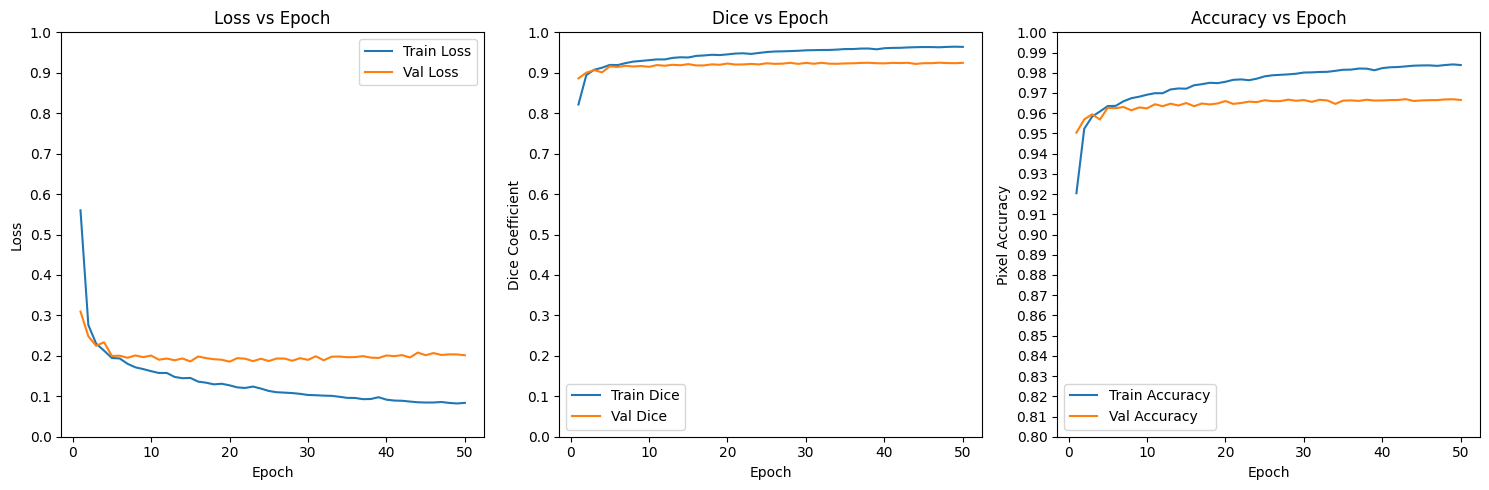

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these are defined from your training loop:
# num_epochs,
# train_loss_list, val_loss_list,
# train_dice_list,  val_dice_list,
# train_acc_list,   val_acc_list

epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(15, 5))

# Loss vs Epoch
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_list, label="Train Loss", linestyle='-')
plt.plot(epochs_range, val_loss_list,   label="Val Loss",   linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# Dice vs Epoch
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_dice_list, label="Train Dice", linestyle='-')
plt.plot(epochs_range, val_dice_list,   label="Val Dice",   linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Dice vs Epoch")
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# Accuracy vs Epoch
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_acc_list,  label="Train Accuracy", linestyle='-')
plt.plot(epochs_range, val_acc_list,    label="Val Accuracy",   linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.ylim(0.8, 1)
plt.yticks(np.arange(0.8, 1.001, 0.01))

plt.tight_layout()
plt.show()


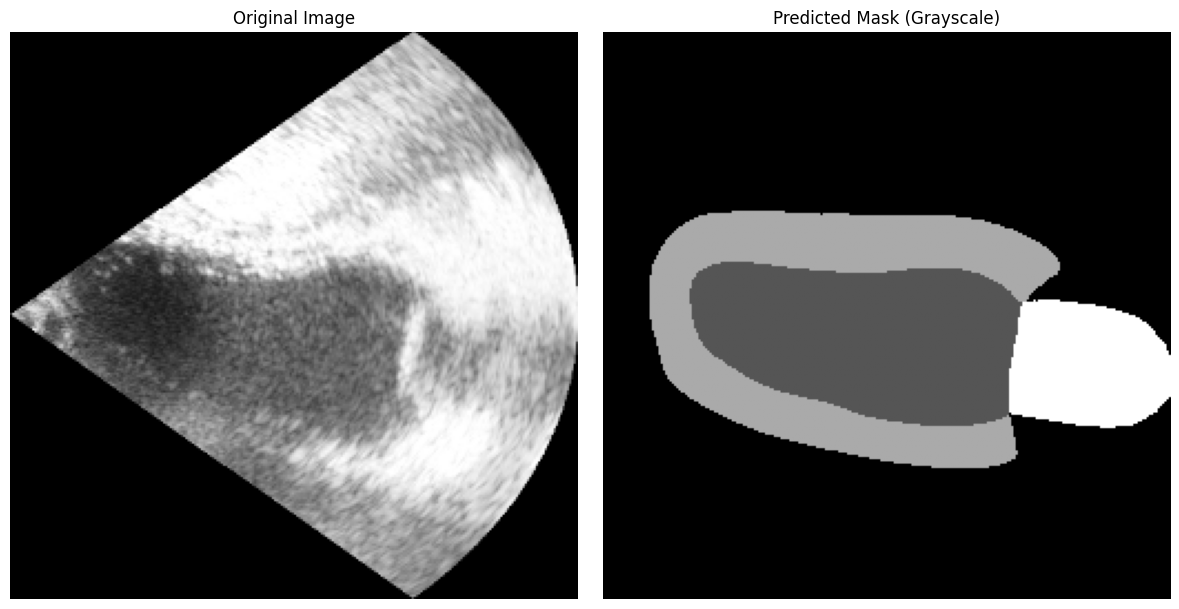

In [23]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2  # For resizing and saving

# ----------------------------
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load the trained model
model_save_path = r"F:\Rohit\LRP\densenet_dice_ce.pth" # Update with your model path
model = smp.Unet(
    encoder_name="densenet121",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,        # Background + three foreground classes
    activation=None   # No activation here; we'll apply softmax manually
)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# ----------------------------
# Load the input .nii.gz file
input_file = r"F:\Rohit\Segmentation CAMUS\Dataset\nii_img\patient0001_2CH_ED.nii.gz"  # Update with your input file
nii_img   = nib.load(input_file)
img_data  = nii_img.get_fdata()

# Select a 2D slice if 3D
if img_data.ndim == 3:
    slice_index = img_data.shape[2] // 2
    img_slice   = img_data[:, :, slice_index]
elif img_data.ndim == 2:
    img_slice = img_data
else:
    raise ValueError(f"Unexpected image dimensions: {img_data.shape}")

# Normalize to [0,1]
img_min, img_max = img_slice.min(), img_slice.max()
if img_max > img_min:
    img_slice = (img_slice - img_min) / (img_max - img_min)

# Resize to 256×256
img_resized = cv2.resize(img_slice.astype(np.float32), (256, 256))

# Prepare tensor: (B=1, C=1, H=256, W=256)
img_tensor = torch.from_numpy(img_resized).unsqueeze(0).unsqueeze(0).to(device)

# ----------------------------
# Run inference
with torch.no_grad():
    logits     = model(img_tensor)               # (1, 4, 256, 256)
    probs      = torch.softmax(logits, dim=1)    # normalize across the 4 classes
    pred_mask  = torch.argmax(probs, dim=1)      # (1, 256, 256)
    pred_mask  = pred_mask.squeeze(0).cpu().numpy().astype(np.uint8)

# ----------------------------
# Optional: save the raw mask as a single‐channel PNG
# Scale classes {0,1,2,3} → {0,85,170,255} for visibility
mask_to_save = (pred_mask * (255 // 3)).astype(np.uint8)
cv2.imwrite("pred_mask_gray.png", mask_to_save)

# ----------------------------
# Display side‐by‐side: original vs. predicted mask in grayscale
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img_resized, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predicted mask
axes[1].imshow(pred_mask, cmap="gray", vmin=0, vmax=3)
axes[1].set_title("Predicted Mask (Grayscale)")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("segmentation_side_by_side_gray.png", bbox_inches="tight", pad_inches=0)
plt.show()


In [ ]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch
import torch.nn.functional as F
import segmentation_models_pytorch as smp

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Metric Functions (unchanged)
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred):
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.size == 0 or coords_pred.size == 0:
        return np.nan
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    return max(d_forward, d_backward)

def mean_absolute_distance_multi(y_true, y_pred):
    distances = []
    channels = y_true.shape[-1]
    for i in range(channels):
        channel_true = y_true[..., i]
        channel_pred = y_pred[..., i]
        mask_true = (channel_true * 255).astype(np.uint8)
        mask_pred = (channel_pred * 255).astype(np.uint8)
        contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not contours_true or not contours_pred:
            distances.append(np.nan)
        else:
            pts_true = np.vstack(contours_true)[:, 0, :]
            pts_pred = np.vstack(contours_pred)[:, 0, :]
            dists = [np.min(np.linalg.norm(pts_pred - pt, axis=1)) for pt in pts_true]
            distances.append(np.mean(dists))
    return np.nanmean(distances)

def compute_mae(y_true, y_pred):
    return mean_absolute_error(y_true.flatten(), y_pred.flatten())

def compute_classification_metrics(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc  = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec  = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function
# -------------------------------

def evaluate_model(model, dataloader, device):
    """
    Runs multiclass evaluation on GPU; moves tensors to CPU only
    when computing NumPy‐based metrics.
    """
    dice_scores, jaccard_scores = [], []
    hausdorff_scores, mae_scores = [], []
    mad_scores = []
    accuracies, precisions, recalls = [], [], []
    correlations = []

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            # send to GPU
            imgs  = imgs.to(device)
            masks = masks.to(device)  # one‐hot floats: (B, C, H, W)

            # forward
            logits   = model(imgs)
            probs    = torch.softmax(logits, dim=1)
            pred_idx = torch.argmax(probs, dim=1)

            # one‐hot encode predictions
            num_classes = masks.shape[1]
            preds_onehot = F.one_hot(pred_idx, num_classes) \
                              .permute(0, 3, 1, 2).float()

            # bring back to CPU for metric loops
            preds_np = preds_onehot.cpu().numpy().transpose(0, 2, 3, 1)
            masks_np = masks.cpu().numpy()       .transpose(0, 2, 3, 1)

            for p, t in zip(preds_np, masks_np):
                dice_scores.append(dice_coefficient(t, p))
                jaccard_scores.append(jaccard_index(t, p))
                hausdorff_scores.append(hausdorff_distance_single(t, p))
                mae_scores.append(compute_mae(t, p))
                mad_scores.append(mean_absolute_distance_multi(t, p))
                acc, prec, rec = compute_classification_metrics(t, p)
                accuracies.append(acc);    precisions.append(prec)
                recalls.append(rec);       correlations.append(compute_correlation(t, p))

    # summary
    print("---- Evaluation Metrics ----")
    print(f"Dice Coef    : {np.nanmean(dice_scores):.4f} ± {np.nanstd(dice_scores):.4f}")
    print(f"Jaccard IoU  : {np.nanmean(jaccard_scores):.4f} ± {np.nanstd(jaccard_scores):.4f}")
    print(f"Hausdorff    : {np.nanmean(hausdorff_scores):.4f} ± {np.nanstd(hausdorff_scores):.4f}")
    print(f"MAE          : {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"MAD          : {np.mean(mad_scores):.4f} ± {np.std(mad_scores):.4f}")
    print(f"Accuracy     : {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Precision    : {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Recall       : {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"Correlation  : {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")

# -------------------------------
# Main
# -------------------------------
if __name__ == "__main__":
    # build your model exactly as before:
    model = smp.Unet(
        encoder_name   = "densenet121",
        encoder_weights= "imagenet",
        in_channels    = 1,
        classes        = 4,
        activation     = None
    )
    # load weights
    model.load_state_dict(torch.load("F:\Rohit\LRP\densenet_dice_ce.pth", map_location=device))
    model.to(device)

    # your val_loader must yield (image_tensor, one_hot_mask_tensor)
    # e.g. masks shaped (B, 4, H, W)
    evaluate_model(model, val_loader, device)


Using device: cuda
---- Evaluation Metrics ----
Dice Coef    : 0.9666 ± 0.0131
Jaccard IoU  : 0.9356 ± 0.0242
Hausdorff    : 2.9805 ± 0.1193
MAE          : 0.0167 ± 0.0066
MAD          : 2.0254 ± 1.2968
Accuracy     : 0.9833 ± 0.0066
Precision    : 0.9666 ± 0.0131
Recall       : 0.9666 ± 0.0131
Correlation  : 0.9554 ± 0.0175


In [ ]:
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch
import torch.nn.functional as F  # for one‐hot
import segmentation_models_pytorch as smp

# -------------------------------
# Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred):
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.size == 0 or coords_pred.size == 0:
        return np.nan
    dists_true_to_pred = [np.min(np.linalg.norm(coords_pred - pt, axis=1)) for pt in coords_true]
    dists_pred_to_true = [np.min(np.linalg.norm(coords_true - pt, axis=1)) for pt in coords_pred]
    hd = max(np.max(dists_true_to_pred), np.max(dists_pred_to_true))/2
    return hd

def mean_absolute_distance_single(y_true, y_pred):
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    cnts_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts_true or not cnts_pred:
        return np.nan
    pts_true = np.vstack(cnts_true)[:, 0, :]
    pts_pred = np.vstack(cnts_pred)[:, 0, :]
    dists = [np.min(np.linalg.norm(pts_pred - pt, axis=1)) for pt in pts_true]
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc  = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec  = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device):
    """
    Multiclass evaluation per channel on GPU:
      - softmax → argmax to get per-pixel class,
      - one-hot–encode into channels,
      - compute metrics for channels 1..3 (lobes).
    """
    num_segments = 4  # background + 3 lobes

    # storage per channel
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.to(device)
    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            # Move inputs to GPU
            imgs  = imgs.to(device)      # (B, C_in, H, W)
            masks = masks.to(device)     # one-hot (B, 4, H, W)

            # Forward pass
            logits = model(imgs)
            if isinstance(logits, tuple):
                logits = logits[0]

            # softmax + argmax on GPU
            probs    = torch.softmax(logits, dim=1)
            pred_idx = torch.argmax(probs, dim=1)  # (B, H, W)

            # one-hot encode predictions: stays on GPU
            preds_onehot = F.one_hot(pred_idx, num_classes=num_segments) \
                              .permute(0, 3, 1, 2).float()

            # Move to CPU for NumPy metrics
            preds_np = preds_onehot.cpu().numpy().transpose(0, 2, 3, 1)  # (B, H, W, 4)
            masks_np = masks.cpu().numpy().transpose(0, 2, 3, 1)

            # Compute per-segment metrics
            for p_mask, t_mask in zip(preds_np, masks_np):
                for seg in range(1, num_segments):
                    p_ch = p_mask[..., seg]
                    t_ch = t_mask[..., seg].astype(np.float32)

                    dice_scores[seg].append(dice_coefficient(t_ch, p_ch))
                    jaccard_scores[seg].append(jaccard_index(t_ch, p_ch))
                    hausdorff_scores[seg].append(hausdorff_distance_single(t_ch, p_ch))
                    mae_scores[seg].append(mean_absolute_error(t_ch.flatten(), p_ch.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(t_ch, p_ch))

                    acc, prec, rec = compute_classification_metrics(t_ch, p_ch)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)
                    correlations[seg].append(compute_correlation(t_ch, p_ch))

    # Print results per lobe
    for seg in range(1, num_segments):
        print(f"---- Metrics for Lobe_{seg} ----")
        print(f"Dice Coef    : {np.nanmean(dice_scores[seg]):.4f} ± {np.nanstd(dice_scores[seg]):.4f}")
        print(f"Jaccard IoU  : {np.nanmean(jaccard_scores[seg]):.4f} ± {np.nanstd(jaccard_scores[seg]):.4f}")
        print(f"Hausdorff    : {np.nanmean(hausdorff_scores[seg]):.4f} ± {np.nanstd(hausdorff_scores[seg]):.4f}")
        print(f"Mean Abs Err : {np.mean(mae_scores[seg]):.4f} ± {np.std(mae_scores[seg]):.4f}")
        print(f"MAD (Bound)  : {np.mean(mad_scores[seg]):.4f} ± {np.std(mad_scores[seg]):.4f}")
        print(f"Accuracy     : {np.mean(accuracies[seg]):.4f} ± {np.std(accuracies[seg]):.4f}")
        print(f"Precision    : {np.mean(precisions[seg]):.4f} ± {np.std(precisions[seg]):.4f}")
        print(f"Recall       : {np.mean(recalls[seg]):.4f} ± {np.std(recalls[seg]):.4f}")
        print(f"Correlation  : {np.mean(correlations[seg]):.4f} ± {np.std(correlations[seg]):.4f}")
        print("-----------------------------\n")

# -------------------------------
# Example usage:
# -------------------------------
if __name__ == "__main__":
    # Build & load your model
    model = smp.Unet(
        encoder_name    = "densenet121",
        encoder_weights = "imagenet",
        in_channels     = 1,
        classes         = 4,
        activation      = None
    )
    model.load_state_dict(torch.load("F:\Rohit\LRP\densenet_dice_ce.pth", map_location=device))

    # val_loader should yield (image_tensor, one_hot_mask_tensor)
    evaluate_model_by_segment(model, val_loader, device)


Using device: cuda
---- Metrics for Lobe_1 ----
Dice Coef    : 0.9353 ± 0.0371
Jaccard IoU  : 0.8806 ± 0.0612
Hausdorff    : 3.4394 ± 1.5999
Mean Abs Err : 0.0106 ± 0.0055
MAD (Bound)  : 2.1521 ± 1.0495
Accuracy     : 0.9894 ± 0.0055
Precision    : 0.9359 ± 0.0597
Recall       : 0.9394 ± 0.0525
Correlation  : 0.9308 ± 0.0366
-----------------------------

---- Metrics for Lobe_2 ----
Dice Coef    : 0.8761 ± 0.0451
Jaccard IoU  : 0.7822 ± 0.0672
Hausdorff    : 4.5545 ± 1.9756
Mean Abs Err : 0.0248 ± 0.0111
MAD (Bound)  : 2.3975 ± 0.9742
Accuracy     : 0.9752 ± 0.0111
Precision    : 0.8775 ± 0.0685
Recall       : 0.8797 ± 0.0588
Correlation  : 0.8637 ± 0.0485
-----------------------------

---- Metrics for Lobe_3 ----
Dice Coef    : 0.9019 ± 0.0797
Jaccard IoU  : 0.8294 ± 0.1108
Hausdorff    : 4.3273 ± 3.9175
Mean Abs Err : 0.0089 ± 0.0058
MAD (Bound)  : 2.5739 ± 1.9274
Accuracy     : 0.9911 ± 0.0058
Precision    : 0.8847 ± 0.1039
Recall       : 0.9332 ± 0.0874
Correlation  : 0.9010 ± 0.